# PyTorch Custom Datasets

We've used some datasets with PyTorch before, but in this notebook, we'll create custom ones for that is how most of them are found.


## Setup


### Importing PyTorch and setting up device-agnostic code


In [189]:
# Importing packages

# Type hinting
from typing import List, Tuple, Dict, Any

# Other
import random
import numpy as np

# File handling
import os
import zipfile
import requests
from pathlib import Path

# Image visualization
from PIL import Image
import matplotlib.pyplot as plt

# Handling data
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

# Modelling
import torch
from torch import nn

In [190]:
# Setting up device-agnostic code
device = 'mps' if torch.mps.is_available() else 'cpu'

### Functions


In [191]:
def walk_through_dir(dir_path: Path) -> None:
    '''Walks through dir_path returning its contents'''
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.'
        )

In [192]:
def plot_transformed_images(
    image_paths: List[Path],
    transform: transforms.Compose,
    n_images: int = 3,
    seed: int | None = None,
) -> None:
    '''
    Selects random images from a path of images and loads/transforms them.
    Then plots the original vs the transformed version
    '''

    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n_images)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original\nSize: {f.size}')
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0)

            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed\nSize: {transformed_image.shape}')
            ax[1].axis(False)

            fig.suptitle(f'Class {image_path.parent.stem}', fontsize=16)

In [193]:
def find_classes(directory: Path | str) -> Tuple[List[str], Dict[str, int]]:
    '''
    Finds the class folder names in a target directory.
    '''

    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(
            f'Couldn\'t find any classes in {directory}... Please check the file structure'
        )

    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [221]:
def display_random_images(
    dataset: ImageFolderCustom | datasets.ImageFolder,
    classes: List[str],
    n: int = 10,
    display_shape: bool = True,
    seed: int | None = None,
) -> None:
    if n > 10:
        n = 10
        display_shape = False
        print(
            f'For display purposes, n shouldn\'t be larger than 10, setting it to t10 and removing shape display'
        )

    if seed:
        random.seed(seed)

    random_sample_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))

    for i, target_sample in enumerate(random_sample_idx):
        target_image, target_label = (
            dataset[target_sample][0],
            dataset[target_sample][1],
        )

        target_image_adjust = target_image.permute(1, 2, 0)

        plt.subplot(1, n, i + 1)
        plt.imshow(target_image_adjust)
        plt.axis('off')
        if classes:
            title = f'Class: {classes[target_label]}'

            if display_shape:
                title = title + f'\nshape: {target_image_adjust.shape}'

            plt.title(title)

## 1. Get data

Our dataset is a subset of the _Food 101_ dataset. _Food 101_ starts with $101$ different classes of food and $1000$ images per class (750 training, 250 testing). We'll only use $3$ of these classes, and only $10$% of the images (~$75$ training, $25$ testing).

We'll be doing this to follow a principle in ML projects, where you want to try things on small scale and then increase the scale when necessary. This is important to speed up how fast you can experiment.


In [195]:
# Setting up data folder
data_path = Path('../data')
image_path = data_path / 'pizza_steak_sushi'

# Creating foder if it doesn't exist
if image_path.is_dir():
    print(f'{image_path} directory already exists... skipping download')
else:
    print(f'{image_path} directory doesn\'t exist, creating directory.')
    image_path.mkdir(parents=True, exist_ok=True)

../data/pizza_steak_sushi directory already exists... skipping download


In [196]:
# Preparing data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as file:
    # Downloading data
    print('Downloading pizza, steak, sushi data...')
    request = requests.get(
        "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
    )
    print('Download complete.')
    file.write(request.content)

Download complete.


In [197]:
# Unzipping file
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping pizza, steak and sushi data...')
    zip_ref.extractall(image_path)

Unzipping pizza, steak and sushi data...


## 2. Data setup and exploration

A standard format for image data in PyTorch is as follows:

```
train/
    class_1/
        image_01.jpg
        image_02.jpg
        ...
    class_2/
        image_67.jpg
        image_68.jpg
        ...
    class_3/
        image_124.jpg
        image_125.jpg
        ...
    ...
test/
    class_1/
        image_992.jpg
        image_993.jpg
        ...
    class_2/
        image_1101.jpg
        image_1102.jpg
        ...
    class_3/
        image_1304.jpg
        image_1305.jpg
        ...
    ...
```

Where each directory inside either `train` or `test`, contains all of the images of the class with its name. This is done to conform with the expected file structure for the `torchvision.datasets.ImageFolder` class.


In [198]:
# Walking through directory
walk_through_dir(dir_path=image_path)

There are 2 directories and 0 images in ../data/pizza_steak_sushi.
There are 3 directories and 0 images in ../data/pizza_steak_sushi/test.
There are 0 directories and 19 images in ../data/pizza_steak_sushi/test/steak.
There are 0 directories and 31 images in ../data/pizza_steak_sushi/test/sushi.
There are 0 directories and 25 images in ../data/pizza_steak_sushi/test/pizza.
There are 3 directories and 0 images in ../data/pizza_steak_sushi/train.
There are 0 directories and 75 images in ../data/pizza_steak_sushi/train/steak.
There are 0 directories and 72 images in ../data/pizza_steak_sushi/train/sushi.
There are 0 directories and 78 images in ../data/pizza_steak_sushi/train/pizza.


In [199]:
# Setting up train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('../data/pizza_steak_sushi/train'),
 PosixPath('../data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

In this section, we'll:

1. get all of the image paths
2. pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata


../data/pizza_steak_sushi/train/pizza/2687575.jpg
Random image path: ../data/pizza_steak_sushi/train/pizza/2687575.jpg
Image class: pizza
Image height: 384
Image width: 512


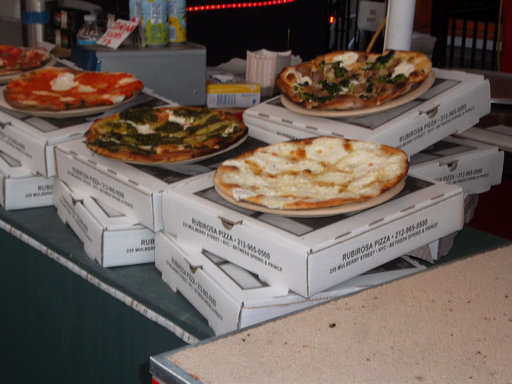

In [200]:
# Setting seed
# random.seed(42)

# Getting all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# Picking random image
random_image_path = random.choice(image_path_list)
print(random_image_path)

# Get image class from path name
image_class = random_image_path.parent.stem

# Opening image
img = Image.open(random_image_path)

# Printing metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

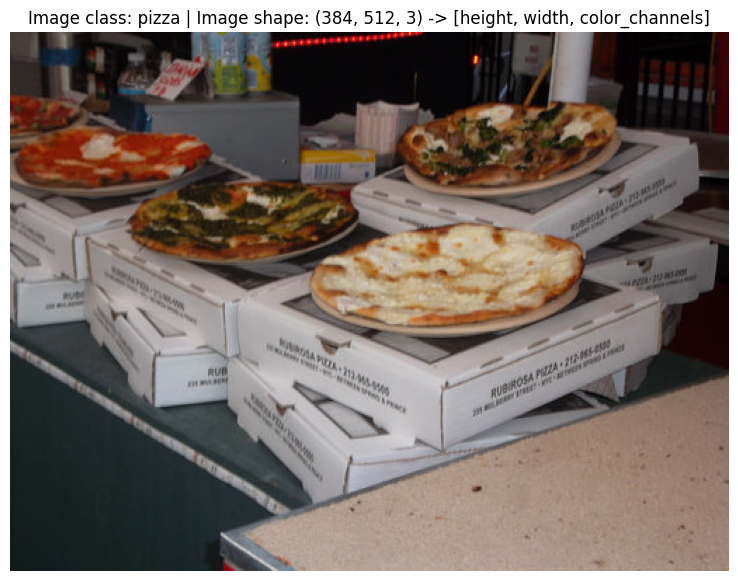

In [201]:
# Visualizing image with matplotlib

# Turning the image as array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(
    f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]'
)
plt.axis(False)

In [202]:
# Visualizing image as array
img_as_array

array([[[ 67,  59,  56],
        [ 67,  59,  56],
        [ 68,  58,  56],
        ...,
        [ 53,   4,   7],
        [ 56,   4,   8],
        [ 59,   2,   8]],

       [[ 68,  60,  57],
        [ 68,  60,  57],
        [ 69,  59,  57],
        ...,
        [ 54,   4,   7],
        [ 55,   3,   7],
        [ 58,   1,   7]],

       [[ 69,  61,  58],
        [ 69,  61,  58],
        [ 70,  60,  58],
        ...,
        [ 54,   4,   7],
        [ 55,   3,   7],
        [ 57,   2,   7]],

       ...,

       [[ 18,  27,  26],
        [ 18,  27,  26],
        [ 18,  27,  26],
        ...,
        [163, 140, 126],
        [168, 145, 131],
        [168, 147, 130]],

       [[ 18,  27,  26],
        [ 18,  27,  26],
        [ 18,  27,  26],
        ...,
        [160, 131, 115],
        [165, 136, 118],
        [164, 137, 116]],

       [[ 18,  27,  26],
        [ 18,  27,  26],
        [ 18,  27,  26],
        ...,
        [155, 122, 103],
        [158, 127, 106],
        [157, 127, 103]]

## 3. Loading image data


### 3.1 Loading image data with Dataset and DataLoader (option 1)

Before we can use our image data with PyTorch, we must first turn the target data into tensors (which in our case is the numerical representation of the images). Then turn the tensors into a `torch.utils.data.Dataset` object, and subsequently a `torch.utils.data.DataLoader`, we'll call these objects `Dataset` and `Dataloader` respectively.


#### 3.1.1 Transforming data with `torchvision.transforms`

Here we'll transform the images, reshaping, augment them through flipping, and finally turn them into tensors.

Through the use of `ToTensor()`, we transform our data that is either in the format of `np.ndarray`s of of `PIL` images, in the shapes of $(H\times W\times C)$ and values in the range $[0,\ 255]$, *to tensors*of shape $(C\times H\times W)$, with values in the range $[0.0, \ 1.0]$.


In [203]:
# Write a transform for image
data_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
    ]
)

In [204]:
# Visualizing transforms with previous image
transformed_img = data_transform(img)

In [205]:
# Visualizing new shape and dtype
transformed_img.shape, transformed_img.dtype

(torch.Size([3, 64, 64]), torch.float32)

##### 3.1.1.1 Visualizing transformed images


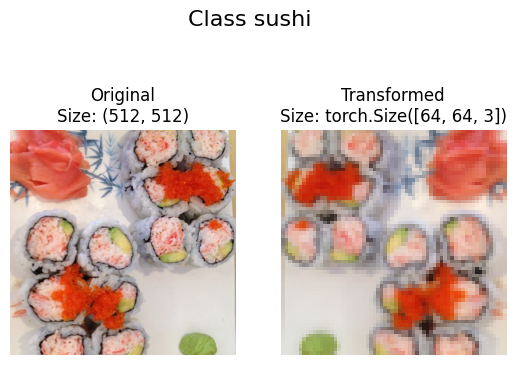

In [206]:
# Visualizing image
plot_transformed_images(
    image_paths=image_path_list,
    transform=data_transform,
    n_images=1,
)

#### 3.1.2 Loading images using `ImageFolder`

We can load image classification using `torchvision.datasets.ImageFolder`


In [207]:
# Creating datasets
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
)

In [208]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: ../data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: ../data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [209]:
# Getting class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [210]:
# Getting class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [211]:
# Checking lengths of dataset
len(train_data), len(test_data)

(225, 75)

#### 3.1.3 Turning image Datasets into DataLoaders

The `DataLoader` turns `Dataset` objects into iterables and can customise the `batch_size` so the model can process `batch_size` images at one time. Batch size is a way of improving training of a model via exposing and optimizing it with a few images at a time.


In [212]:
# Turning train and test datasets into DataLoader'set
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=False
)

In [213]:
# Visualizing info on iterable
img, label = next(iter(train_dataloader))

img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### 3.2. Loading image data with custom Dataset (option 2)

There are a few steps we need to get through here, the first is to be able to load the images from files, the second would be to get the class names from the dataset, and finally, we want to be able to get classes as a dictionary from the dataset.

Some of the advantages of loading image data with a custom dataset are that you can create a dataset out of almost anything, and it doesn't get limited by PyTorch's pre build `Dataset` functions. This approach is not infallible though, and although we can create a `Dataset` object out of almost anything, it doesn't mean that it'll work. Another possible _con_ is that using a custom `Dataset` often results in writing more code, and with it comes the risk of introducing more errors and causing performance issues.

All datasets in PyTorch subclass `torch.utils.data.Dataset`.


#### 3.2.1 Creating a helper function to get class names

The custom function will need to get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format, _see section 2_), raise an error if the class names aren't found (probably because of the directory structure), and finally turn the class names into a dict and a list and return them.


In [214]:
# Finding class names with str path
found_classes, found_classes_idx = find_classes('../data/pizza_steak_sushi/train')

In [215]:
# Finding class names with Path object
found_classes, found_classes_idx = find_classes(train_dir)

#### 3.2.2 Creating custom `Dataset` to replicate `ImageFolder`

This isn't as trivial as using the aforementioned `ImageFolder` object provided by `torchvision. There are quite a few steps that should be followed:

1. Subclass `torch.utils.data.Dataset`
2. Initialize the subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
   - paths - paths of images
   - transform - the transform we'd like to use
   - classes - a list of the target classes
   - class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of the dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed an index


In [216]:
# Write a custom dataset
class ImageFolderCustom(Dataset):
    def __init__(
        self,
        target_dir: str | Path,
        transform: transforms.Compose | Any = None,
    ) -> None:
        super().__init__()
        self.paths = list(Path(target_dir).glob('*/*.jpg'))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_dir)

    def __len__(self) -> int:
        '''Returns the total number of samples.'''
        return len(self.paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        '''Returns one sample of data, data and label (X, y).'''
        img = self.load_image(index=index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx

        return img, class_idx

        return super().__getitem__(index)

    def load_image(self, index: int) -> Image.Image:
        '''Opens an image via path and returns it.'''
        image_path = self.paths[index]
        return Image.open(image_path)

#### 3.2.3 Creating new transforms and datasets


In [217]:
# Creating transforms
train_transforms = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor(),
    ]
)

In [218]:
# Creating custom datasets
train_data_custom = ImageFolderCustom(target_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(target_dir=test_dir, transform=test_transforms)

In [219]:
test_data_custom.classes

['pizza', 'steak', 'sushi']

#### 3.2.4 Turn custom loaded images into `DataLoader`s


In [229]:
# Creating Dataloaders
train_dataloader_custom = DataLoader(
    dataset=train_data_custom, batch_size=BATCH_SIZE, num_workers=1, shuffle=True
)
test_dataloader_custom = DataLoader(
    dataset=test_data_custom, batch_size=BATCH_SIZE, num_workers=1, shuffle=True
)

### 3.3 Visualizing random images


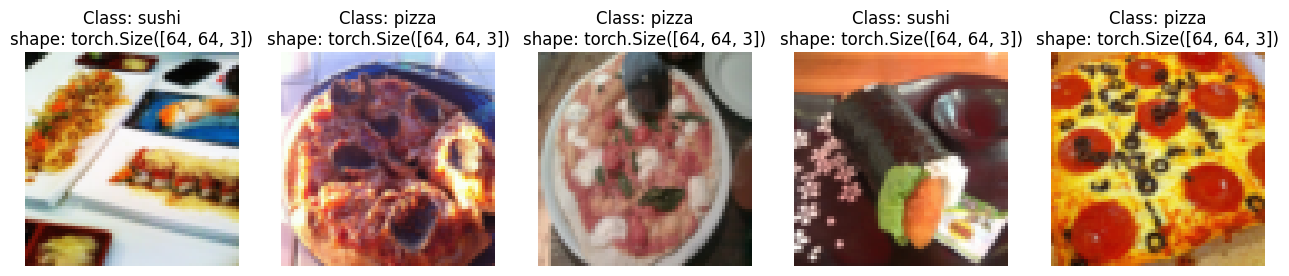

In [223]:
# Displaying random images from ImageFolder Dataset
display_random_images(train_data, n=5, classes=class_names, seed=42)

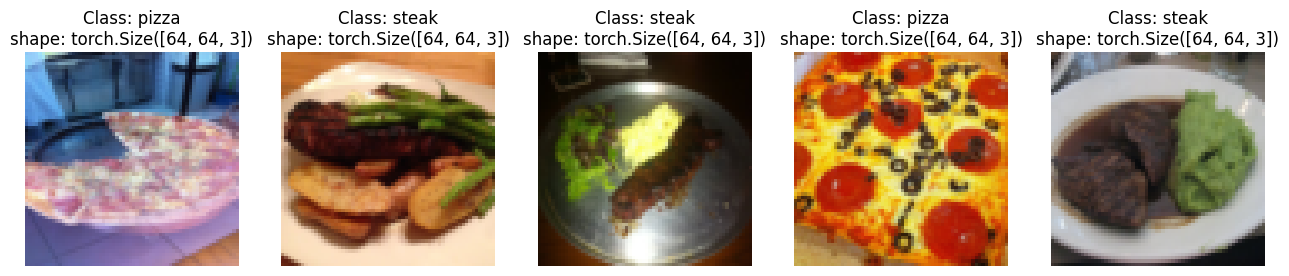

In [228]:
# Displaying random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, n=5, classes=class_names, seed=42)

### 3.4 Other forms of transforms (_data augmentation_)

_Data augmentation_ is the process of artificially adding diversity to the training data. In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results. in a model that's more generalizable to unseen data. We'll Look into one particular type of _data augmentation_ used to train PyTorch vision models to state of the art levels.

This type of _Data Augmentation_ is called **_TrivialAugment_**. Here each image is transformed by a single, randomly chosen operation at a randomly chosen strength. This is done in a minimalist, parameter-free, automatic way. The `TrivialAugmentWide` class from `torchvision.transforms`, has the `num_magnitude_bins` parameter to set how "_intense_" (therefore magnitude) the transformation will be. It is $31$ (maximum) by default.


In [245]:
# Creating new transforms
data_augmentation_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.ToTensor(),
    ]
)
simple_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor(),
    ]
)

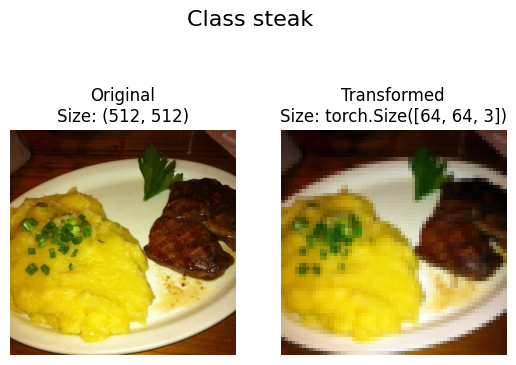

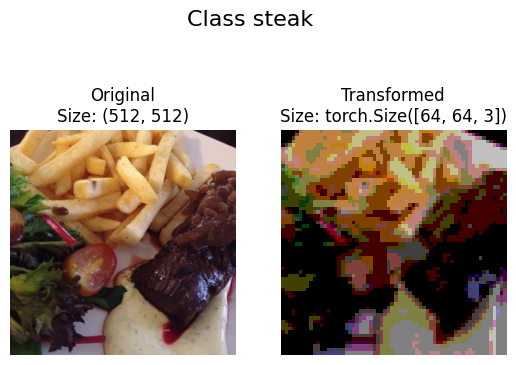

In [244]:
# Plotting transformed images
plot_transformed_images(
    image_paths=image_path_list, transform=training_transform, n_images=2
)

## 4. Creating Model
